In [94]:
import sys
from pathlib import Path
project_root = Path.cwd().parent.parent
sys.path.append(str(project_root))
project_root = Path.cwd().parent
sys.path.append(str(project_root))
from visualization.utils import defaultColors
from helpers import load_from_path, save_image, get_dfs

import pandas as pd
from pathlib import Path
import numpy as np

In [95]:
exp = "GAS-004"
# agg_type = "agg"
agg_type = "raw"

df, df_mean_std = get_dfs(exp)

In [96]:

def is_float_column(column, df):
    return df[column].dtype in [np.float64, np.float32]


def get_color(column, df):
    labels = df[column]
    if is_float_column(column, df):
        # Use a continuous colormap for float-valued columns
        norm = plt.Normalize(labels.min(), labels.max())
        cmap = plt.cm.viridis
        colors = cmap(norm(labels))
    else:
        # Use distinct colors for category or integer-valued columns
        unique_labels = np.unique(labels)
        cmap = plt.cm.tab10
        colors_dict = {label: cmap(i) for i, label in enumerate(unique_labels)}
        colors = np.array([colors_dict[label] for label in labels])

    return colors
def scatter_plot(df, x, y, cc, mc, filter_data="", fig=None, ax=None, c_index=[0]):

    # print(df)
    if filter_data == "filter":
        df = df[df["C_OH_C_Zn"] > 1.6]
        df = df.reset_index(drop=True)

    colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]
    alphas = [1, 0.5]

    markers_all = ["o", "d"]
    markers_dict = {
        label: markers_all[idx % len(markers_all)]
        for idx, label in enumerate(df[mc].unique())
    }
    markers = [markers_dict[label] for label in df[mc]]


    for i in range(df.shape[0]):
        row = df.iloc[i]
        color = colors[c_index[0] % len(colors)]
        marker = markers[i]
        sc = ax.plot(
            row[x],
            row[y],
            marker=marker,
            color=color,
            markersize=10,
            markeredgewidth=0.5,
            markeredgecolor="black",
            alpha=alphas[c_index[0] % len(alphas)],
        )

    
    x_data = df[x]
    y_data = df[y]
    
    def pareto_frontier(Xs, Ys, maxX=True, maxY=True):
        myList = sorted([[Xs[i], Ys[i]] for i in range(len(Xs))], reverse=maxX)
        p_front = [myList[0]]
        for pair in myList[1:]:
            if maxY:
                if pair[1] >= p_front[-1][1]:
                    p_front.append(pair)
            else:
                if pair[1] <= p_front[-1][1]:
                    p_front.append(pair)
        
        
        # add min and max combination
        p_front.append([Xs.max(), Ys.min()])
        p_front.append([Xs.min(), Ys.max()])
        
        np_p_front = np.array(p_front)
        # sort by x
        np_p_front = np_p_front[np_p_front[:,0].argsort()]
        return np_p_front[:,0], np_p_front[:,1]
    
    x_pf, y_pf = pareto_frontier(x_data, y_data)
    
    line = ax.plot(x_pf, y_pf, color=color, linestyle="--", zorder=40, linewidth=2)
    
    # legend with markers
    handles = []
    for label, marker in markers_dict.items():
        handles.append(ax.plot([], [], marker=marker, color="k", markersize=6, linestyle="None")[0])
    
    #add color as square to legend
    handles.append(ax.plot([], [], marker="s", color=color, markersize=6, linestyle="None")[0]) 
    handles.append(ax.plot([], [], marker="s", color=colors[c_index[0]-1 % len(colors)], markersize=6, linestyle="None")[0]) 
    
    legend = ["Sobol", "Optimization", "Raw Samples", "MVaR"]
    
    ax.legend(handles, legend, loc="upper right", fontsize=12)

    # custom colorbar
    if is_float_column(cc, df):
        # Add a colorbar if 'cc' is a float column
        sm = plt.cm.ScalarMappable(
            cmap=plt.cm.viridis,
            norm=plt.Normalize(vmin=df[cc].min(), vmax=df[cc].max()),
        )
        sm.set_array([])
        fig.colorbar(sm, ax=ax, label=cc)

    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.grid(True)
    c_index[0] += 1
    print(c_index[0])

    return fig, ax


1
2


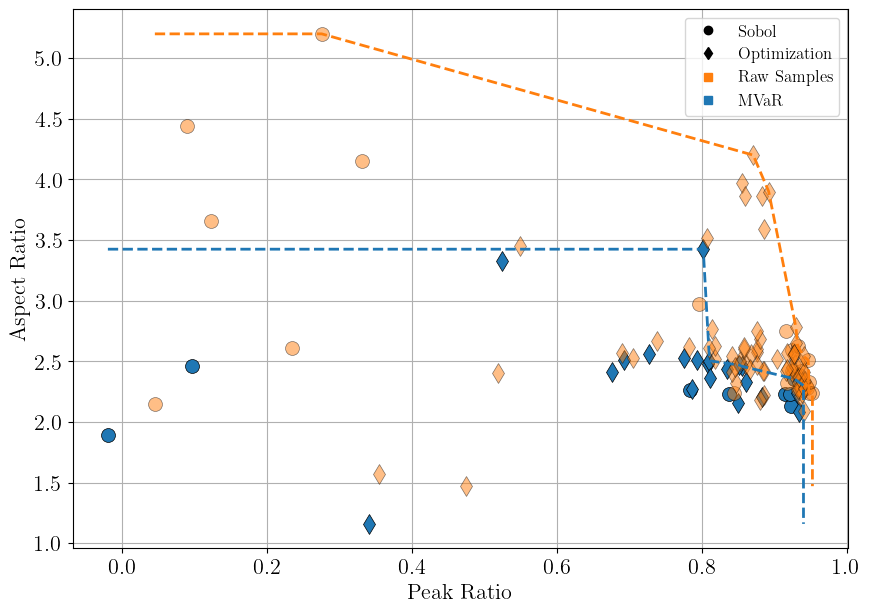

In [97]:
# %config InlineBackend.figure_format='svg'
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D

plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Helvetica"],
        # font size
        "font.size": 16,
    }
)

plots_list = [
    ["Peak Ratio_VaR", "Aspect Ratio_VaR", "initial_sampling", "initial_sampling", "filter"],
]

x, y, cc, mc, filter_data = plots_list[0]

c_index = [0]

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
fig, ax = scatter_plot(df_mean_std, x, y, cc, mc, filter_data, fig, ax)

fig, ax = scatter_plot(
    df,
    x.replace("_mean", "").replace("_std", "").replace("_VaR", ""),
    y.replace("_mean", "").replace("_std", "").replace("_VaR", ""),
    cc.replace("_mean", "").replace("_std", "").replace("_VaR", ""),
    mc.replace("_mean", "").replace("_std", "").replace("_VaR", ""),
    filter_data,
    fig,
    ax,
)
# fig.show()
save_image(
    fig,
    Path("./daw/awd"),
    f"{exp}/{agg_type}/overlay/{cc}/{mc}",
    f"{x}+{y}+{cc}+{mc}+{filter_data}".replace("/", "_"),
)
